In [33]:
import pandas as pd
%matplotlib inline
from collections import Counter
#from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import random
import re
import operator


# source: https://www.kaggle.com/datasnaek/youtube-new/data

In [8]:
trending = pd.DataFrame.from_csv('USvideos_1.csv')
trending_UK = pd.DataFrame.from_csv("GBvideos.csv")
trending_CA = pd.DataFrame.from_csv("CAvideos.csv")

categories = pd.DataFrame.from_csv("categories.csv",index_col=None)
trending= trending.merge(categories,on="category_id")
trending_UK = trending_UK.merge(categories,on="category_id")
trending_CA = trending_CA.merge(categories,on="category_id")

In [9]:
# Voeg ratios toe
trending['like_view_ratio'] = trending.likes / trending.views
trending['dislike_view_ratio'] = trending.dislikes / trending.views
trending["like_dislike_ratio"] = trending.likes / trending.dislikes

In [10]:
# regelt timecodes
# we moeten tijden indelen in blokken van een uur dus 23:30 gaat in het blok van 00:00 en 04:45 in 05:00
times = [[int(y[0]),int(y[1])] for y in [x.split("T")[1][:-8].split(":") for x in trending.publish_time]]
timecodes = [] 
for hour, minutes in times:
    if minutes==0:
        timecodes.append(hour)
    else:
        if hour != 23:
            timecodes.append(hour+1)
        else:
            timecodes.append(0)
trending["timecode"]= pd.Series(timecodes,index=trending.index)

In [12]:
publish_dates = []
for x in trending.publish_time:
    temp = x.split("T")[0].replace("-",".")
    publish_dates.append( temp[2:5]+str(int(temp[-2:])+1)+temp[-6:-3])
trending["publish_date"]=publish_dates


In [20]:
# calculates the time until a video becomes trending
originalTimes = trending[["trending_date","publish_date","timecode"]]
time_until_trending= []
for x in originalTimes.iterrows():
    trendDate = x[1][0].split(".")
    publDate  = x[1][1].split(".")
    timeCode  = int(x[1][2])
    hours  = abs(int(trendDate[1])-int(publDate[1]))*24
    months = abs(int(trendDate[2])-int(publDate[2]))*720
    total = timeCode+hours+months
    time_until_trending.append(total)
trending["time_until_trending"]=time_until_trending

#preparation for wordclouds
contro = trending[trending.like_dislike_ratio < 1].title.values

In [21]:
def color_func_red(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 50%%, %d%%)" % random.randint(40, 80)

def color_func_green(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(100, 50%%, %d%%)" % random.randint(40, 80)

def color_func_blue(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(200, 50%%, %d%%)" % random.randint(40, 80)

In [ ]:
def gen_word_cloud(data, color, collo):
    
    # Kleuren bepalen
    if color == 1:
        func = color_func_red
    elif color == 2:
        func = color_func_green
    else:
        func = color_func_blue
    
    text = " ".join([re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"]", "", str(x).lower()) for x in data])

    wordcloud = WordCloud(width=2000, height=1000, relative_scaling = 1, max_words=40, collocations=collo, regexp=r"\w[\S']+",
                          stopwords = stopwords.words('english') # set or space-separated string
                          ).generate(text)
    plt.figure( figsize=(20,10) )
    plt.imshow(wordcloud.recolor(color_func=func, random_state=3),
               interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [32]:
def stripTitle(titles,country):
    result= []
    stop = stopwords.words("english")
    for x in titles:
        temp = re.sub(r"[!.\(\)\[\],\´\';\'\-:\'\"\|\/\*\?\&]", "", str(x).lower())
        temp = re.sub(r" {2,}", " ", temp)
        
        for y in temp.split(" "):
            if y not in stop and re.fullmatch(r"\D+",y):
                result.append(y)
    return result

def stripTitlesToDict(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)            
    words = pd.DataFrame.from_dict(resultDict,orient='index')
    words.columns=[country]
    words[country]=words[country]/len(words[country])
    return words

def stripTitlesCount(titles,country):
    result= stripTitle(titles,country)
    resultDict=Counter(result)
    return resultDict
    

# Hieronder alle tijdelijk uitgecommente code, ivm errors of work in progress

#preparation results code, still needs to be recreated
results=[]
for x in trending.title:
    temp= trending[trending.title==x]
    if len(temp)!=1:
        results.append((max(temp.views)-min(temp.views)/len(temp)))
    else:
        results.append(temp.views.max())
trending["increase_views"]=results

## Welke termen zijn het meest voorkomend in titels van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?

### Methode
Om deze vraag te kunnen beantwoorden zal de library WordCloud worden gebruikt. Eerst worden alle titels uit het dataframe gehaald. Vervolgens worden de titels aan elkaar geplakt als een string met spaties ertussen in plaats van bijvoorbeeld punten, aangezien WordCloud dit als input wilt. Om een WordCloud te kunnen genereren in kleur zal een functie worden geschreven, waaraan parameters kunnen worden meegegeven om de kleur te bepalen.
De kleur is afhankelijk van de like/dislike ratio. Bij een like/dislike ratio groter dan 1 wordt de WordCloud groen gekleurd, bij precies 1 blauw en bij kleiner dan 1 rood. Voordat de wordclours gegenereerd zullen worden, worden eerst de stopwords uit de library NLTK eruit gehaald.


In [24]:
# alles biagrams met negatieve ratio in titels
#gen_word_cloud(contro, 1, True)

In [25]:
# Alle enkele woorden
titles = trending[trending.like_dislike_ratio > 1].title.values
#gen_word_cloud(titles, 2, False)

In [26]:
# Alle biagrams met hoge ratio
#gen_word_cloud(titles, 2, True)

In [34]:
titles = stripTitlesCount(trending.title.values, "US")
titleslike = stripTitlesCount(trending[trending.like_view_ratio > 0.10].title.values, "US")
titlesdislike = stripTitlesCount(trending[trending.dislike_view_ratio > 0.10].title.values, "US")

alles = sorted(titles.items(), key=operator.itemgetter(1), reverse=True)
like = sorted(titleslike.items(), key=operator.itemgetter(1), reverse=True)
dislike = sorted(titlesdislike.items(), key=operator.itemgetter(1), reverse=True)

print(alles[:20])
print(like[:20])
print(dislike[:20])

[('official', 2097), ('video', 1389), ('trailer', 1104), ('ft', 697), ('new', 693), ('music', 569), ('audio', 561), ('live', 556), ('hd', 539), ('vs', 538), ('day', 492), ('makeup', 462), ('first', 441), ('christmas', 435), ('star', 430), ('best', 401), ('make', 393), ('super', 392), ('black', 391), ('full', 361)]
[('official', 87), ('video', 76), ('mv', 55), ('bts', 54), ('audio', 40), ('live', 40), ('ft', 32), ('day', 27), ('camila', 27), ('cabello', 26), ('makeup', 25), ('cover', 25), ('feat', 24), ('lyric', 24), ('holiday', 23), ('dodie', 23), ('things', 22), ('music', 22), ('trailer', 22), ('beauty', 21)]
[('fcc', 7), ('repeals', 4), ('net', 4), ('neutrality', 4), ('rules', 4), ('psa', 3), ('chairman', 3), ('ajit', 3), ('pai', 3)]


### Results

## Welke termen zijn het meest voorkomend in beschrijvingen van trending video's en verschillen deze termen bij variërende like/dislike ratio’s?


### Methode
Bij deze deelvraag is hetzelfde gedaan als bij deelvraag 1, alleen wordt nu de beschrijving bekeken in plaats van de titels. Een extra stap die hier genomen zal worden zal zijn dat woorden die in zo goed als elke beschrijving voorkomen er ook nog uitgehaald worden. Dit zijn worden als ‘like’ & ‘subscribe’.


In [27]:
# Alle beschrijvingen bekijken, enkele woorden.
description = trending.description.values
#gen_word_cloud(description, 3, False)

### Results

## Is er een verband tussen de ratio van het aantal likes en het aantal views?


### Methode
Voordat de ratio tussen het aantal likes en dislikes wordt berekend wordt de data genormaliseerd. Dit zal worden gedaan door ratio’s te maken, berekent als (Likes / Views) per video. Dit zal worden gesorteerd van een laag naar hoog aantal views en zal hierna worden geplot. De x-as zal logaritmisch worden geschaald om het grote verschil in views goed te kunnen weergeven.


# MOET ANDER PLOTJE WORDEN

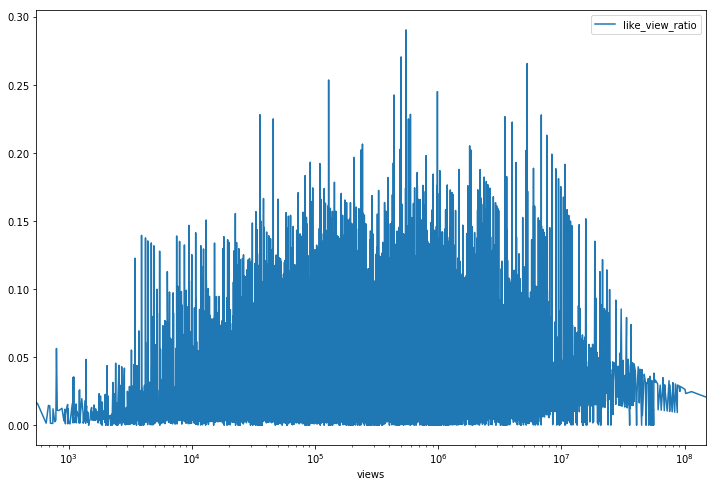

In [28]:
# Ratio likes ten opzichte van views.
trending.sort_values(by='views').plot(x='views', y="like_view_ratio", figsize=(12,8), logx=True)

### Results

## Is er een verband tussen de ratio van het aantal dislikes en het aantal views?


### Methode
De methode werkt hetzelfde als bij deelvraag 3, behalve dat er nu een ratio wordt gemaakt van Dislikes / Views per video. Ook hier wordt er gesorteerd van laag naar hoog en zal de x-as logaritmisch geschaald worden.


In [29]:
#Code hier

### Results

## Zijn er verschillen in titels tussen US, GB en CA?

# NIET AF
### Methode
Om de titels te kunnen vergelijken zullen eerst alle engelse stopwoorden met behulp van de library NLTK verwijderd worden. Daarna worden voor ieder land de meest voorkomende woorden in de titel in een frequentietabel gestopt. De frequenties van het aantal woorden zal worden genormaliseerd door deze te delen door het totaal aantal voorkomende woorden in het land. Hierna worden de top voorkomende woorden genomen, bepaald door het totaal dat het woord voorkomt in alle landen (US, GB, CA). Dit wordt geplot in een grouped bar chart. Er wordt een plot gemaakt van de top woorden van ieder land. Dit resulteert in 3 grouped bar charts die uitgaan van de verschillende topwoorden.


In [35]:
#code

### Results

##  Wat is de gemiddelde toename aan views voor trending video's die meerdere dagen in de trending staan?


### Methode
# ontbreekt

In [36]:
#code

### Results

##  Wat zijn de meest voorkomende categorieën en hoe verschilt dat bij verschillende like/view ratio’s?

### Methode
# Stond nog een comment bij
Om deze vraag te beantwoorden zullen de categorieën worden geteld. Vervolgens zullen de categorieën worden geteld voor alle video’s die een like/view ratio van hoger dan 0.10 likes per view hebben, en ook de categorieën bij een dislike/view ratio van hoger dan 0.10.


In [37]:
#code

### Results

## Is er een verband tussen de publicatie tijd en het aantal views?

### Methode
# Moet nog

In [38]:
# code

### Results